In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import math
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

Шансы - это отношение вероятности успеха к вероятности неудачи.

odds = p / (1 - p), где p - вероятность положительного исхода. Если шансы > 1, то 
вероятность положительного исхода, больше чем вероятность отрицательного. Шансы могут принимать значения от 0 до +Inf.

Если мы возьмем натуральный логарифм от шанса, то он будет лежать в промежутке (0; +Inf) при odds > 1 и в промежутке (-Inf; 0) при odds < 1. Получается, что каждый раз, когда вероятность положительного исхода выше, мы будем получать положительные значения логарифма и наоборот.

Итого логистическая регрессия представляет из себя уравнение, в котором справа, находится линейная комбинация наших предикторов, а слева логарифм шансов положительного исхода зависимой переменной.

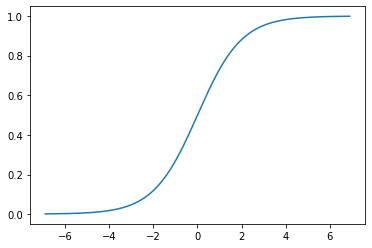

In [39]:
# Покажем как, вероятность положительного исхода (Y) зависит от логарифма 
# шансов положительного исхода (X).

posibilities = np.arange(.001, 0.9999, 0.001)
logit = np.log(posibilities / (1 - posibilities))
plt.plot(logit, posibilities)

In [155]:
data = pd.read_csv("https://stepic.org/media/attachments/course/524/train.csv")

Сначала построим Intercept only model.

In [156]:
model = sm.formula.glm("Survived ~ 1",
                       family=sm.families.Binomial(), data=data).fit()
# В нашем случае мы увидим только один Intercept
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      890
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -593.33
Date:                Thu, 23 Feb 2023   Deviance:                       1186.7
Time:                        17:20:10   Pearson chi2:                     891.
No. Iterations:                     4   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4733      0.069     -6.870      0.000      -0.608      -0.338
==============================================================================
"""

В данном случае это означает, что у нас есть зависимая переменная Survived (Y).
Мы хотим построить модель Y = Intercept.

Мы получим, что log(p / (p-1)) = Intercept, логарифм шансов на выживание будет описан одним числом

In [157]:
# Посчитаем сколько человек погибло, а сколько выжило
survived_table = data.groupby("Survived").count().loc[:, :"PassengerId"]
# Посчитаем шансы на выживание
odds = survived_table.PassengerId[1] / survived_table.PassengerId[0]
intercept = math.log(odds) # это и есть intercept
print(intercept)
"""
Мы как бы говорим модели, чтобы она подобрала нам число, которое максимально точно
опишет нового пассажира.
"""
# Зная Intercept можно посчитать вероятность выживания
p = math.exp(intercept) / (1 + math.exp(intercept))
print(p)

-0.4732877044469254
0.38383838383838387


Также мы увидим, что Intercept значимо отличается от 0. Значит шансы значимо меньше единицы. Значит вероятность выжить значимо меньше 0,5.

Н0: odds = 1
H1: odds != 1

Если бы мы много раз повторяли эксперимент и каждый раз вычисляли логарифм шансов, то при условии справедливости нулевой гипотезы, наш Intercept распределился бы нормально вокруг среднего равного 0, со стандартной ошибкой среднего. И поделив Intercept на стандартную ошибку, мы ответим на вопрос: "На сколько стандартных отклонений отклонился наш коэффициент". Отсюда посчитаем p_value.

In [158]:
"""
Мы как бы говорим модели, чтобы она подобрала нам число, которое максимально точно
опишет нового пассажира.
"""
# Зная Intercept можно посчитать вероятность выживания
p = math.exp( -0.8472979) / (1 + math.exp( -0.8472979))
print(p * 50)

14.999999584065643


Теперь построим модель с одним предиктором.

In [159]:
model = sm.formula.glm("Survived ~ Sex",
                       family=sm.families.Binomial(), data=data).fit()
# В нашем случае мы увидим только один Intercept
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      889
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -458.90
Date:                Thu, 23 Feb 2023   Deviance:                       917.80
Time:                        17:21:05   Pearson chi2:                     891.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2605
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.0566      0.129      8.191      0.000       0.804       1.309
Sex[T.male]    -2.5137      0.167    -15.036      0.000      -2.841      -2.186
===============================================================================
"""

Теперь проинтепретируем результаты. Для начала построим табличку сопряженности между полом, и тем выжил человек или нет.

In [179]:
table_survived = data.groupby(["Survived", "Sex"]).count().loc[:, :"PassengerId"]

# Шансы выжить для мужчин
male_odds = table_survived.PassengerId[1][1] / table_survived.PassengerId[0][1]

# Шансы выжить для женщин
female_odds = table_survived.PassengerId[1][0] / table_survived.PassengerId[0][0]

# Теперь можно расчитать Intecept
intercept = math.log(female_odds)

# Далее найдем отношение шансов выжить для мужчин к шансам выжить для женщин
odds_ratio = male_odds / female_odds

# Коэффициент при независимой переменной
coef_sex_male = math.log(odds_ratio)

Мы расчитали только коэффициент для ситуации, когда человек является мужчиной, тк, зная, что он мужчина, мы точно можем утверждать, что он не женщина. Если мы создадим 2 столбика: один - является ли человек женщиной, второй - является ли человек мужчиной, то между ними будет линейная взаимосвязь, поэтому один столбик выбрасывается и уходит в Intercept.

В нашем случае, мы оцениваем логарифм шансов на выживание.

log(p/(p-1)) = 1.0566 - 2.5137 * Sex_Male

Соответственно если человек - женщина, то мы просто получим логарифм шансов выжить для женщины, однако если это мужчина, мы его как бы оштрафуем и получим
логарифм шансов положительного исхода для мужчин.

Это легко доказать, исходя и свойства логарифмов:
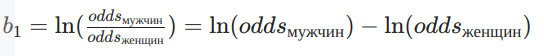